Alessandro Beccani 931651
# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>

## <span style="color:blue">  Numerical exercises 7</span>


The first task is to use the MD/MC code to print out instantaneous values of potential energy per particle, $U/N$, along equilibrated Monte Carlo simulations</span> (of $M=5\times 10^5$ MC steps and where the Metropolis acceptance ratio has been fixed approximately to 50%) in the following thermodynamic conditions:
- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$), $Delta = 0.055$
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$), $Delta = 0.1$
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$), $Delta = 0.5$ 

1. Once this data has been produced, compute and make pictures with a python script of the autocorrelation functions of $U/N$ to approximately estimate how large the blocks in your simulations should be.
2. Use the same data to study, with a python script, the estimation of the statistical uncertainties of the expectation value of $U/N$ for different size of the blocks in the data blocking technique, from $L=M/N=10$ to $L=5\times 10^3$, being $N$ the number of blocks. Make pictures of these statistical uncertainties as a function of $L$.</span> What you observe in the statistical uncertainties after that the block size is large enough (from the point of view of the data blocking technique)?

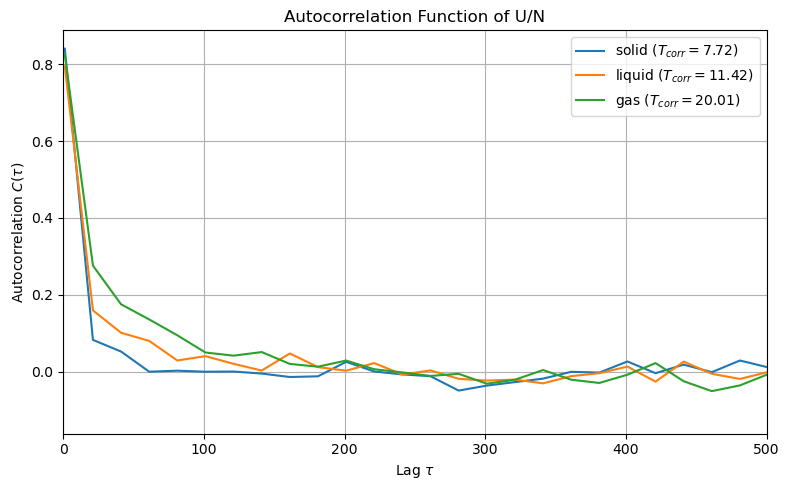

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Corrected autocorrelation function
def autocorrelation(data, lag):
    if len(data) <1:
        return
    avg = np.mean(data)
    var = np.var(data)
    lagged_avg = 0
    for i in range(len(data) - lag):
        lagged_avg += (data[i] - avg) * (data[i + lag] - avg)
    lagged_avg /= (len(data) - lag)
    return lagged_avg / var

# Exponential decay function for fitting
def exp_decay(lag, T_corr):
    return np.exp(-lag / T_corr)

# Plot function for autocorrelation
def plot_autocorrelation(plt, state, lags, autocorr, fit_params):
    plt.plot(lags, autocorr, label=f'{state} ($T_{{corr}}={fit_params[0]:.2f}$)')
    #plt.plot(lags, exp_decay(lags, *fit_params), linestyle='--', label=f'{state}')
    plt.title('Autocorrelation Function of U/N')
    plt.xlabel('Lag $\\tau$')
    plt.ylabel('Autocorrelation $C(\\tau)$')
    plt.grid(True)

# Define states
states = ["solid", "liquid", "gas"]

# Create the plot
plt.figure(figsize=(8, 5))

for state in states:
    # Load U/N data
    U_data = np.loadtxt('./OUTPUT/es_7/' + state + '/instant_potential_energy.dat')
    
    # Compute autocorrelation for multiple lags
    max_lag = 5000
    lags = np.arange(1, max_lag, 20)
    autocorr = np.zeros(len(lags))
    
    for i, lag in enumerate(lags):
        autocorr[i] = autocorrelation(U_data, int(lag))
    
    # Fit the autocorrelation data to an exponential decay model
    popt, pcov = curve_fit(exp_decay, lags, autocorr, p0=[100], bounds=(1, 10000))  # Initial guess for T_corr
    # Plot autocorrelation and the fit
    plot_autocorrelation(plt, state, lags, autocorr, popt)
plt.xlim(0,500)
plt.tight_layout()
plt.legend()
plt.show()


The correlation times were obtained by fitting the autocorellation with the function $e^{t/t_c}$, the fit results are shown in the plot legend. Although it's recommended to make the blocks a few times the correlation lenght, the correlation times found are not likely to be sufficient as a scale for the block size. This is probably due to my poor performance in fitting the autocorrelation functions.

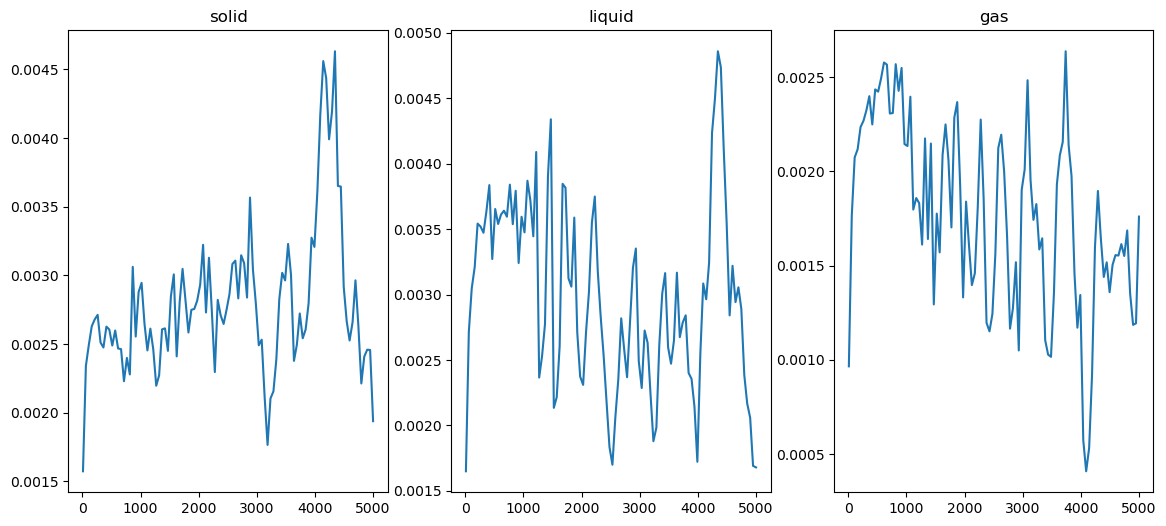

In [41]:
def block_data(data, L):
    """
    Divides the data into blocks of size L and returns the block averages.
    Truncates data to make it divisible by L.
    """
    N = len(data) // L  # Number of blocks
    if N == 0:
        return np.array([])  # Handle case where L is too large
    truncated_length = N * L
    trimmed_data = data[:truncated_length]
    blocks = trimmed_data.reshape((N, L))
    block_averages = blocks.mean(axis=1)
    return block_averages

def compute_statistical_uncertainty(block_averages):
    """
    Computes the standard error of the mean from block averages.
    """
    N = len(block_averages)
    if N == 0:
        return None
    mean = np.mean(block_averages)
    variance = np.var(block_averages)#, ddof=1)  # Unbiased estimator
    std_error = np.sqrt(variance / N)
    return std_error

def analyze_block_sizes(data, L_values):
    """
    For each block size L in L_values, computes the statistical uncertainty
    of the mean U/N using data blocking.
    """
    uncertainties = []
    valid_L = []    
    for L in L_values:
        block_avg = block_data(data, L)
        if len(block_avg) == 0:
            print(f"Block size L={L} is too large for the data. Skipping.")
            continue
        std_err = compute_statistical_uncertainty(block_avg)
        if std_err is not None:
            uncertainties.append(std_err)
            valid_L.append(L)   
    return valid_L, uncertainties

#Data Blocking and Statistical Uncertainty
L_min = 10
L_max = 5000
num_L = 100  # Number of L values to test
L_values = np.linspace(L_min,L_max, num=num_L, dtype=int)

# Create the plot
plt.figure(figsize=(14, 6))
plot_id = 131
for state in states:
    # Load U/N data
    U_data = np.loadtxt('./OUTPUT/es_7/' + state + '/instant_potential_energy.dat')
    # Analyze block sizes
    plt.subplot(plot_id)
    #plt.xlim(0,1000)
    valid_L, uncertainties = analyze_block_sizes(U_data, L_values)
    # Plotting
    plt.plot(valid_L, uncertainties, linestyle='-')
    plt.title(state)
    plot_id += 1
plt.show()

The statistical uncertainties stablize (in order of magnitude) after few hundreds of steps*, although its exact value soon starts to oscillate. The reason why increasing the block size stops being convenient is that once each block contains enough steps to surpass the correlation time, the uncertainty is due to the satistical fluctuations rather than the correlations between data which justifies data blocking. Another thing I'd consider is that in this specific case the data size is 20000 steps, so as the block size approaches this magnitude the number of blocks one can obtain is now smaller, reducing the reduction in uncertainty due to averaging.

*Uncomment  #plt.xlim(0,1000) which sets the x-axis limit to see that it stops growing at about 200 steps for the solid and liquid states, and about 300-400 for the gas. This suggests that the correlation time ratios are correct, although the correlation times themselves seem too optimistically small.

In the same conditions shown above, we show the obtained average values and uncertainties for the potential energy per particle, $U/N$, the pressure $P$ and the radial distribution function $g(r)$ in LJ units. The results for the radial distribution function, $g(r)$ obtained with the MC NVT are compared with those obtained with Molecular Dynamics NVE simulations in similar thermodynamic conditions.

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def _plot(plt, filename, ylabel):
    x, flush, y, err_prog = np.loadtxt(filename, unpack=True)
    plt.errorbar(x, y, yerr=err_prog)
    plt.xlabel('NBlocks')
    plt.ylabel(ylabel)
    plt.grid(True)

general_title = "Potential energy per particle $U/N$ and pressure P for the "

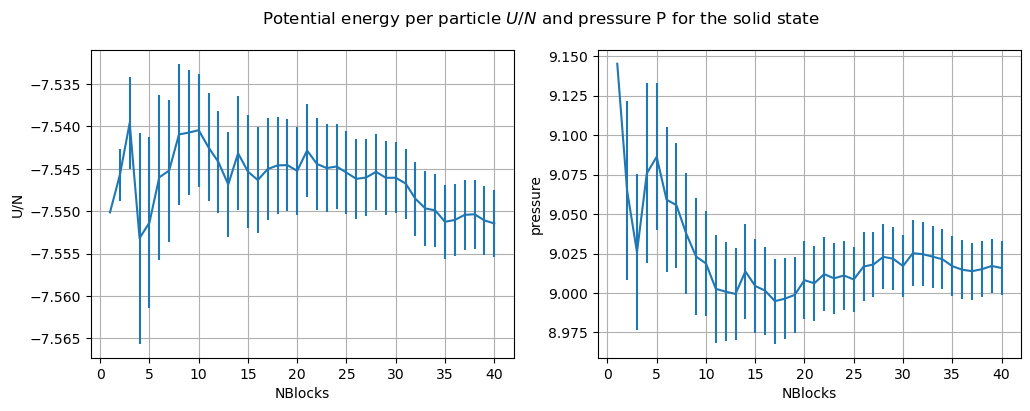

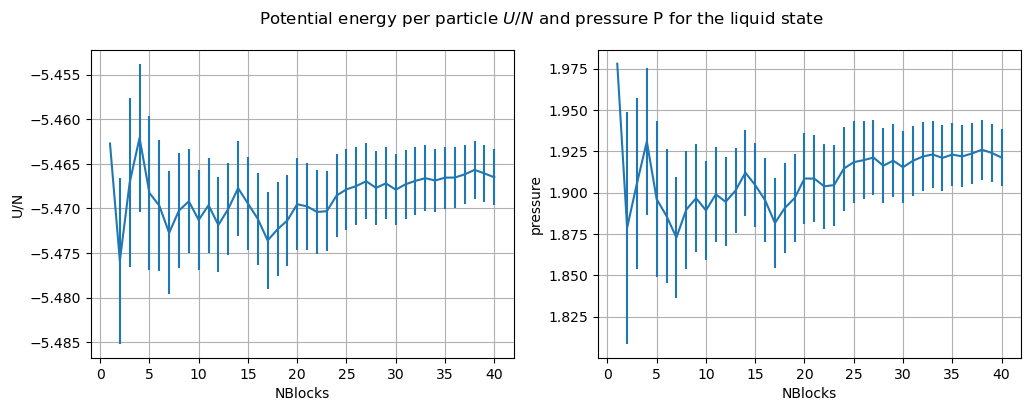

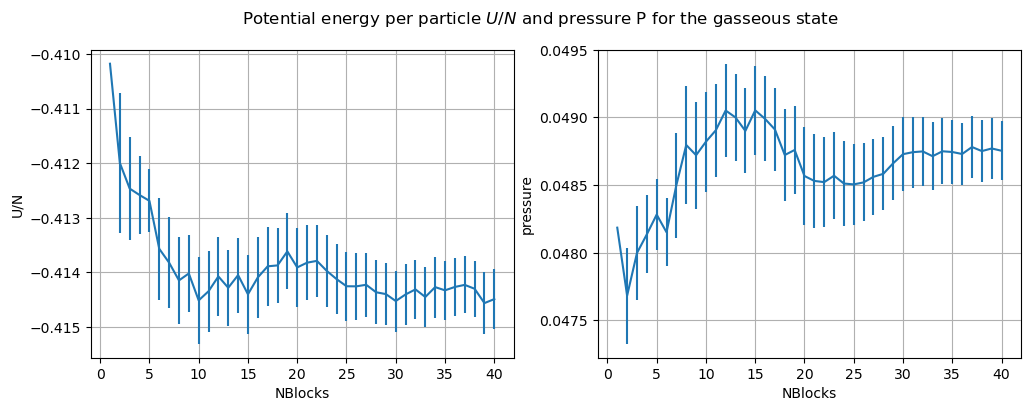

In [18]:
plt.figure(figsize=(12, 4))
plt.suptitle(general_title + "solid state")
plt.subplot(1, 2, 1)
_plot(plt, "./OUTPUT/es_7/solid/potential_energy.dat", 'U/N')

plt.subplot(1, 2, 2)
_plot(plt, "./OUTPUT/es_7/solid/pressure.dat", 'pressure')
plt.show()
print()

plt.figure(figsize=(12, 4))
plt.suptitle(general_title + "liquid state")
plt.subplot(1, 2, 1)
_plot(plt, "./OUTPUT/es_7/liquid/potential_energy.dat", 'U/N')

plt.subplot(1, 2, 2)
_plot(plt, "./OUTPUT/es_7/liquid/pressure.dat", 'pressure')
plt.show()
print()

plt.figure(figsize=(12, 4))
plt.suptitle(general_title + "gasseous state")
plt.subplot(1, 2, 1)
_plot(plt, "./OUTPUT/es_7/gas/potential_energy.dat", 'U/N')

plt.subplot(1, 2, 2)
_plot(plt, "./OUTPUT/es_7/gas/pressure.dat", 'pressure')
plt.show()
print()

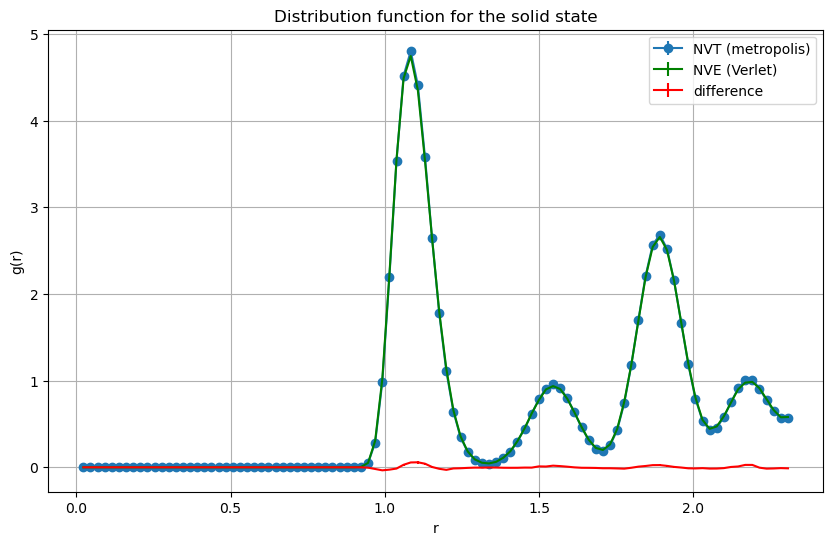

In [49]:
def plot_g(r, avg, avg2, sigma, sigma2, title, xlabel, ylabel):
	plt.figure(figsize=(10, 6))
	plt.errorbar(r, avg, yerr=sigma, fmt='o-', label='NVT (metropolis)')	
	plt.errorbar(r, avg2, yerr=sigma2, fmt='-', label='NVE (Verlet)', color = 'green')
	sigma_diff = np.sqrt(sigma**2+sigma2**2)
	plt.errorbar(r, avg - avg2, sigma_diff, label="difference", color = 'red')
	plt.legend()
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	plt.title(title)
	plt.grid(True)
	plt.show()

r, g, s = np.loadtxt("../NSL_SIMULATOR/OUTPUT/es_7/solid/gofr_METRO.dat", unpack=True)
r2,g2,s2 = np.loadtxt("../NSL_SIMULATOR//OUTPUT/es_7/solid/gofr_VERLET.dat", unpack=True)
plot_g(r, g, g2, s, s2, "Distribution function for the solid state","r","g(r)")

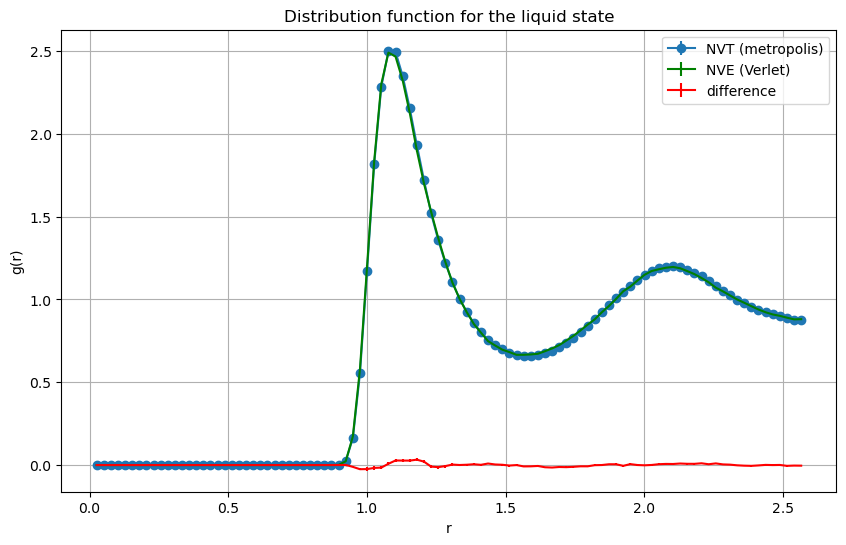

In [47]:
r, g, s = np.loadtxt("../NSL_SIMULATOR/OUTPUT/es_7/liquid/gofr_METRO.dat", unpack=True)
r2,g2,s2 = np.loadtxt("../NSL_SIMULATOR//OUTPUT/es_7/liquid/gofr_VERLET.dat", unpack=True)
plot_g(r, g, g2, s, s2, "Distribution function for the liquid state","r","g(r)")

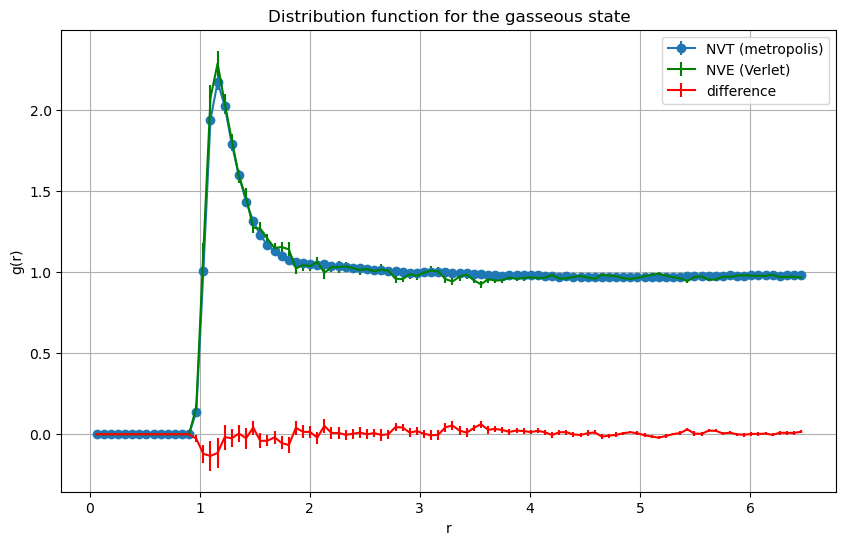

In [48]:
r, g, s = np.loadtxt("../NSL_SIMULATOR/OUTPUT/es_7/gas/gofr_METRO.dat", unpack=True)
r2,g2,s2 = np.loadtxt("../NSL_SIMULATOR//OUTPUT/es_7/gas/gofr_VERLET.dat", unpack=True)
plot_g(r, g, g2, s, s2, "Distribution function for the gasseous state","r","g(r)")

These graphs have been obtained after a refined equilibration for the NVE, as the only difference that I've found in the distribution function, between the simulations run with the two methods, was due to the unstable temperature that characterize the NVE. Stable simulations lead to very similar curves (as shown in the graphs).